<a href="https://colab.research.google.com/github/ricky-kiva/dl-deep-tf-cv-advanced/blob/main/1_a1_bboxes_birds_caltech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Object Localization on Caltech Birds**

Connecting Google Drive

In [18]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Set data path

In [32]:
DATA_DIR = '/content/drive/My Drive/Datasets/TF3 C3 W1 Data/'

Import packages

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

Function: Dataset to numpy

In [ ]:
def dataset_to_numpy(dataset, batch_size=0, N=0):

  take_dataset = dataset.shuffle(1024) # take first '1024' data, put into buffer, & randomly shuffle the data

  if batch_size > 0:
    take_dataset = take_dataset.batch(batch_size) # groups dataset elements into batches of size 'batch_size'

  if N > 0:
    take_dataset = take_dataset.take(N) # take the first `N` element

  print(f"Executing eagerly: {tf.executing_eagerly()}")
  if tf.executing_eagerly():
    ds_images, ds_bboxes = [], []

    # convert each data to numpy, assign to corresponding array
    for img, bbox in take_dataset:
      ds_images.append(img.numpy())
      ds_bboxes.append(bbox.numpy())

    return (np.array(ds_images, dtype=object),
            np.array(ds_bboxes, dtype=object))

Function: Read dataset images with original bounding box

In [ ]:
def read_image_tfds_with_original_bbox(data):
  img = data['image']
  bbox = data['bbox']

  # in `tf.shape()`, the order is (height, width, channel)
  shape = tf.shape(img)
  factor_x = tf.cast(shape[1], tf.float32)
  factor_y = tf.cast(shape[0], tf.float32)

  # reverse normalization, multiplied by corresponding value (width or height)
  bbox_list = [bbox[1] * factor_x,
               bbox[0] * factor_y,
               bbox[3] * factor_x,
               bbox[2] * factor_y]

  return img, bbox_list

Function: Draw bounding boxes on image array

In [ ]:
def draw_bbox_on_image(img, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
  cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)

def draw_bboxes_on_image_array(img, boxes, color=[], thickness=5):
  boxes_shape = boxes.shape
  if not boxes_shape: # check whether it's an empty array
    return

  # check if it has 'pred' & 'actual' bboxes
  # check if 'bboxes' has size of 4 (xmin, ymin, xmax, ymax)
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')

  # `boxes_shape` has `shape` of `(2, 4)`. It iterates over the bounding boxes (2)
  for i in range(boxes_shape[0]):
    draw_bbox_on_image(img, boxes[i, 1], boxes[i, 0], boxes[i, 3], boxes[i, 2], color[i], thickness)

  return img

Set IoU threshold constant

In [ ]:
IOU_THRESHOLD = 0.6

Function: Display digit images with boxes

In [55]:
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

  n = min(len(images), 10)

  fig = plt.figure(figsize=(20,4)) # make new figure
  plt.title(title) # set title
  plt.yticks([]) # disable ticks
  plt.xticks([])

  for i in range(n):
    ax = fig.add_subplot(1, n, (i+1)) # (row, column, subplot location)
    width, height, _ = images[i].shape

    # assign 'bboxes' to 'bboxes_to_plot' array
    bboxes_to_plot = []
    if len(pred_bboxes) > i:
      bbox = pred_bboxes[i]
      bbox = [bbox[0] * height,
              bbox[1] * width,
              bbox[2] * height,
              bbox[3] * width]
      bboxes_to_plot.append(bbox)

    if len(bboxes) > i:
      bbox = bboxes[i]
      if bboxes_normalized == True:
        bbox = [bbox[0] * height,
              bbox[1] * width,
              bbox[2] * height,
              bbox[3] * width]
      bboxes_to_plot.append(bbox)

    # draw bounding boxes
    img_to_draw = draw_bboxes_on_image_array(img=images[i],
                                             boxes=np.asarray(bboxes_to_plot),
                                             color=[(255,0,0), (0, 255, 0)])

    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_to_draw) # show the image on subplot

    # display IoU
    if len(iou) > i:
      color = 'black'
      if (iou[i][0] < IOU_THRESHOLD):
        color = 'red'

      # `ax.transAxes`: text positioning made relative to the axes
      ax.text(0.2, -0.3, f"IoU: {iou[i][0]}", color=color, transform=ax.transAxes)

Function: Get Train dataset for visualization ([Caltech Birds - 2010](http://www.vision.caltech.edu/visipedia/CUB-200.html))

In [28]:
import tensorflow_datasets as tfds

def get_viz_train_dataset():
  dataset, info = tfds.load('caltech_birds2010', split='train', data_dir=DATA_DIR, download=False, with_info=True)
  print(f"Dataset Info: {info}\n")

  # applies function `read_image_tfds_with_original_bbox()` to each element in the dataset
  # `num_parallel_calls=16`: process up to 16 elements in parallel
  viz_train_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)

  return viz_train_dataset

Instantiate visualization train dataset

In [34]:
viz_train_dataset = get_viz_train_dataset()

(viz_train_images, viz_train_bboxes) = dataset_to_numpy(viz_train_dataset)

Dataset Info: tfds.core.DatasetInfo(
    name='caltech_birds2010',
    full_name='caltech_birds2010/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_dir='/content/drive/My Drive/Datasets/TF3 C3 W1 Data/caltech_birds2010/0.1.1',
    file_format=tfrecord,
    download_size=659.14 MiB,
    dataset_size=659.64 MiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=200),
        'label_name': Text(sha

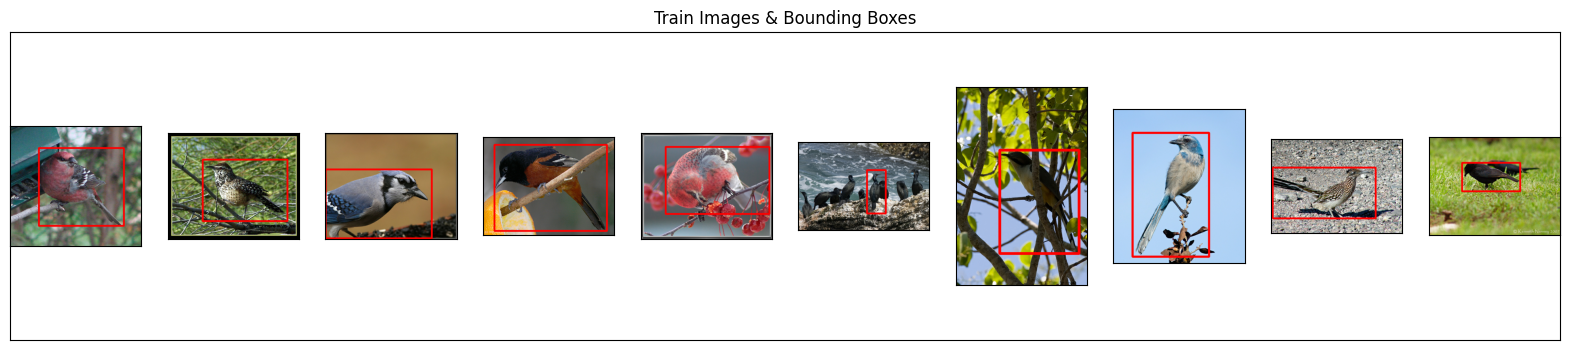

In [56]:
display_digits_with_boxes(images=np.array(viz_train_images),
                          pred_bboxes=np.array([]),
                          bboxes=np.array(viz_train_bboxes),
                          iou=np.array([]),
                          title="Train Images & Bounding Boxes")